In [1]:
import os, sys
import numpy as np
import torch
from data_loader import *
from preprocess.acf import *
from preprocess.gaussianize import *
from model.torch_tcn import *
import matplotlib.pyplot as plt

import yaml
import joblib
if torch.cuda.is_available():
  dev = "cuda:0"
else:
  dev = "cpu"  
device = torch.device(dev)

In [2]:
root = "./QuantGAN"
sys.path.append(root)
generator_path = './result/'

file_name = 'SP500_daily'

In [3]:
with open('./configs/config.yaml', 'r') as config_file:
    config = yaml.safe_load(config_file)
num_epochs = config['train']['num_epochs']

In [4]:
standardScaler1 = joblib.load(f'./data/{file_name}_standardScaler1.pkl')
standardScaler2 = joblib.load(f'./data/{file_name}_standardScaler2.pkl')
gaussianize = joblib.load(f'./data/{file_name}_gaussianize.pkl')
log_returns = joblib.load(f'./data/{file_name}_log_returns.pkl')
log_returns_preprocessed = joblib.load(f'./data/{file_name}_log_returns_preprocessed.pkl')

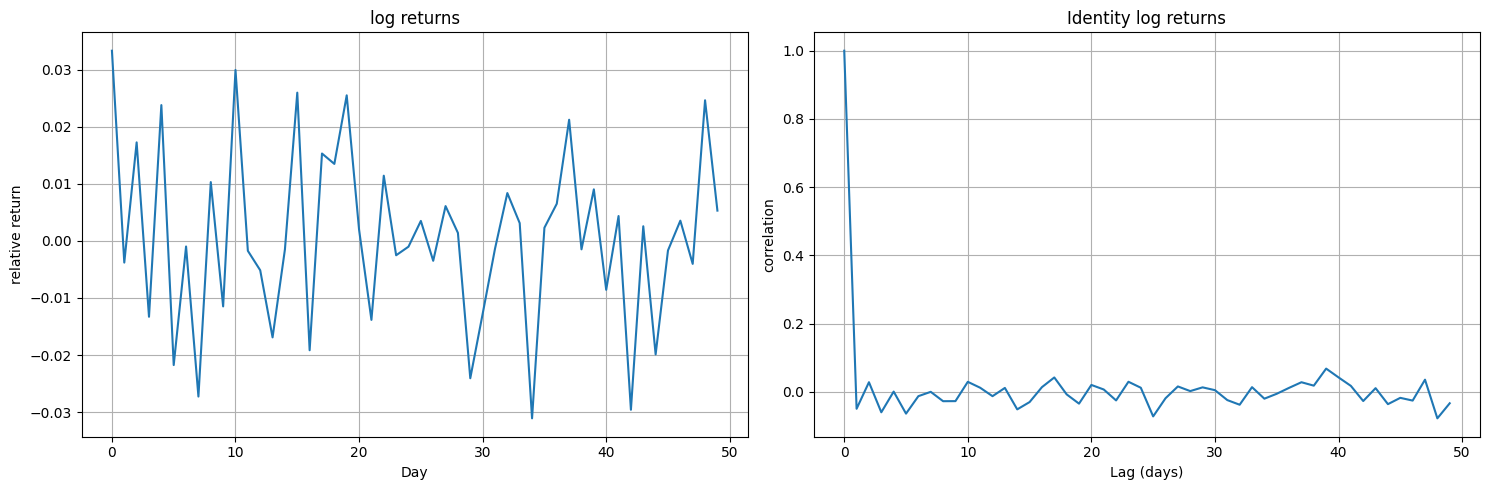

In [5]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 5))

#axs[0].plot(returns[:50])
axs[0].plot(log_returns[0:50])
axs[0].set_title('log returns')
axs[1].plot(acf(log_returns, 50))
axs[1].set_title('Identity log returns')

for ax in axs: ax.grid(True)
plt.setp(axs[0], xlabel='Day')
plt.setp(axs[1], xlabel='Lag (days)')
plt.setp(axs[0], ylabel='relative return')
plt.setp(axs[1], ylabel='autocorrelation')
axs[1].set_ylabel('correlation')
plt.tight_layout()

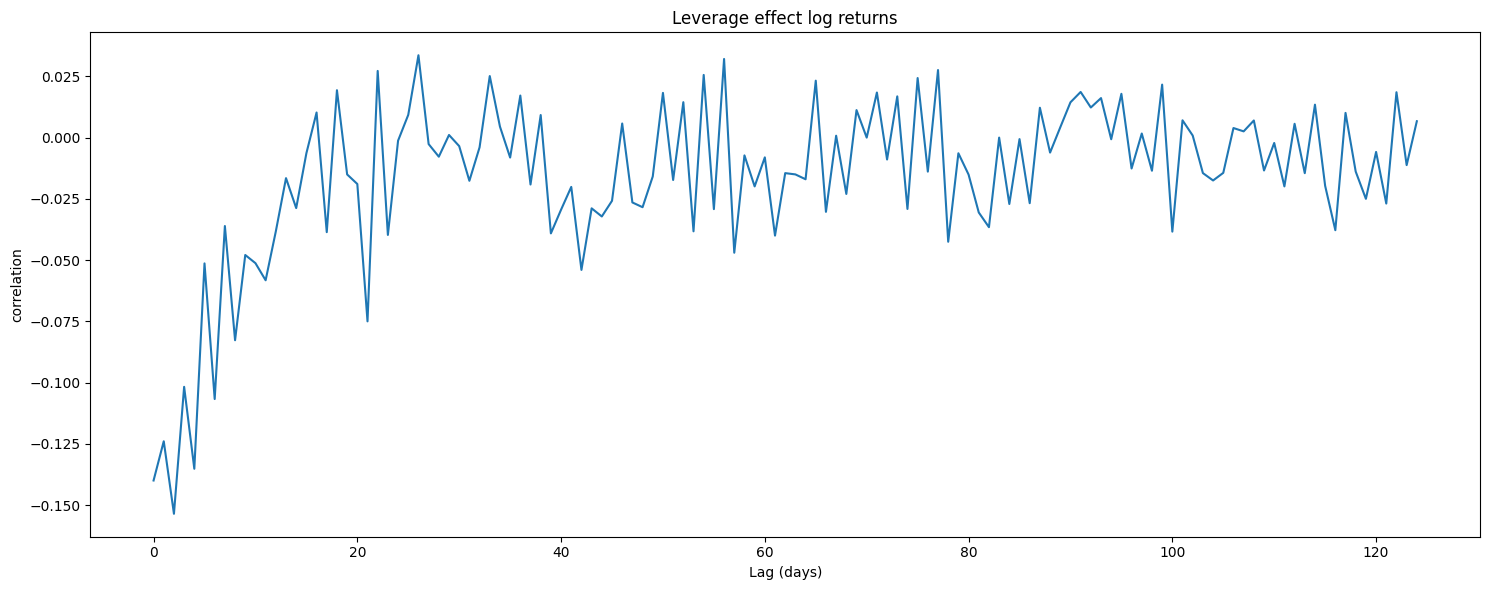

In [6]:
fig, ax = plt.subplots(figsize=(15,6))
ax.plot(acf(log_returns, 125, le=True))
ax.set_title('Leverage effect log returns')
plt.setp(ax, xlabel='Lag (days)')
plt.setp(ax, ylabel='autocorrelation')
ax.set_ylabel('correlation')
plt.tight_layout()

In [7]:
# Receptive Field Size 127 from paper
log_returns_rolled = rolling_window(log_returns_preprocessed, 127)

(-4.0, 4.0)

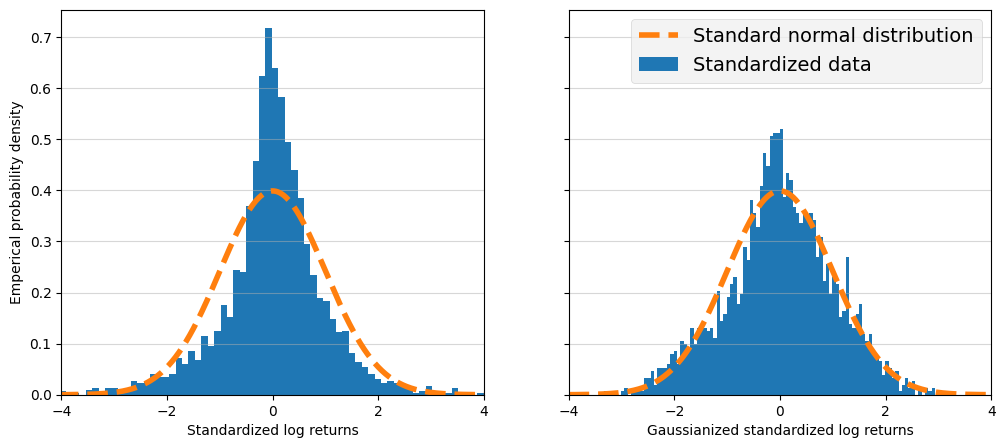

In [8]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 5), sharey=True, sharex=True)
# Log returns before and after the lambert W inverse transform respectively (both standardized). 
plt.style.use('fivethirtyeight')

ax[0].hist(standardScaler1.transform(log_returns), bins=100, density=True)
x_range = np.linspace(*ax[0].get_xlim(), num=1000)
ax[0].plot(x_range, norm.pdf(x_range), linestyle='dashed')

ax[1].hist(log_returns_preprocessed, bins=100, density=True)
x_range = np.linspace(*ax[1].get_xlim(), num=1000)
ax[1].plot(x_range, norm.pdf(x_range), linestyle='dashed')

# add a grid to compare easily
ax[0].yaxis.grid(True, alpha=0.5)
ax[1].yaxis.grid(True, alpha=0.5)

ax[1].legend(['Standard normal distribution', 'Standardized data'])
ax[0].set_ylabel('Emperical probability density')
ax[0].set_xlabel('Standardized log returns')
ax[1].set_xlabel('Gaussianized standardized log returns')

ax[0].set_xlim(-4, 4)

In [9]:
######################
### Load the model ###
######################
wandb_name = 'sleek-jazz-162'
generator = torch.load(f'{generator_path}trained_generator_{file_name}_{wandb_name}_epoch_{num_epochs-1}.pth')   
generator.eval()

noise = torch.randn(100, 3, 2500).to(device)
y = generator(noise).cpu().detach().squeeze()
y = (y - y.mean(axis=0))/y.std(axis=0)
y = standardScaler2.inverse_transform(y)
y = np.array([gaussianize.inverse_transform(np.expand_dims(x, 1)) for x in y]).squeeze()
y = standardScaler1.inverse_transform(y)

# some basic filtering to redue the tendency of GAN to produce extreme returns
y = y[(y.max(axis=1) <= 2 * log_returns.max()) & (y.min(axis=1) >= 2 * log_returns.min())]
#y -= y.mean()
print(y.shape)

(98, 2500)


Text(0, 0.5, 'Cumalative log return')

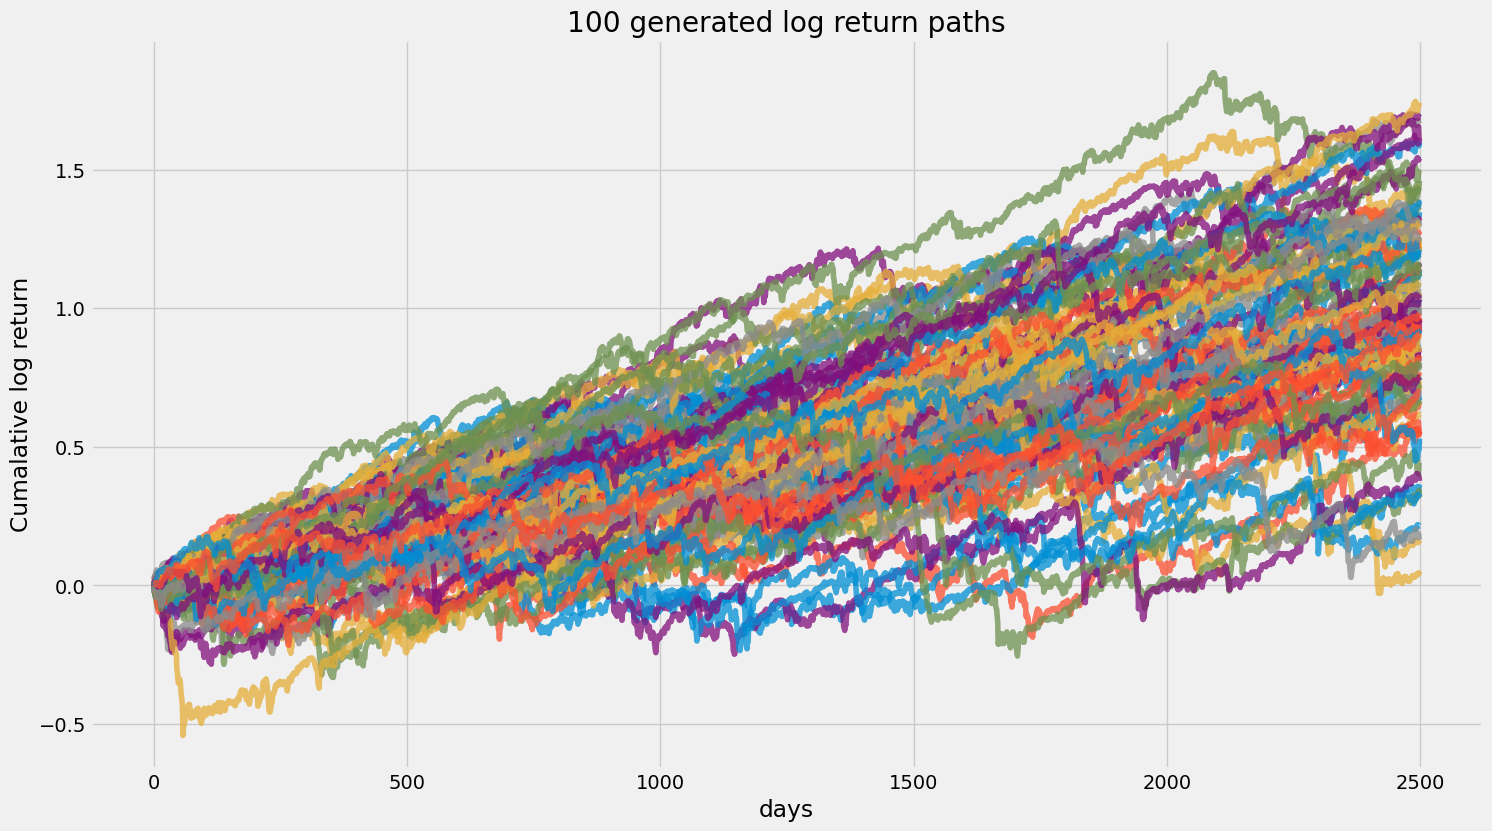

In [10]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(np.cumsum(y[0:], axis=1).T, alpha=0.75)
ax.set_title('100 generated log return paths'.format(len(y)))
ax.set_xlabel('days')
ax.set_ylabel('Cumalative log return')

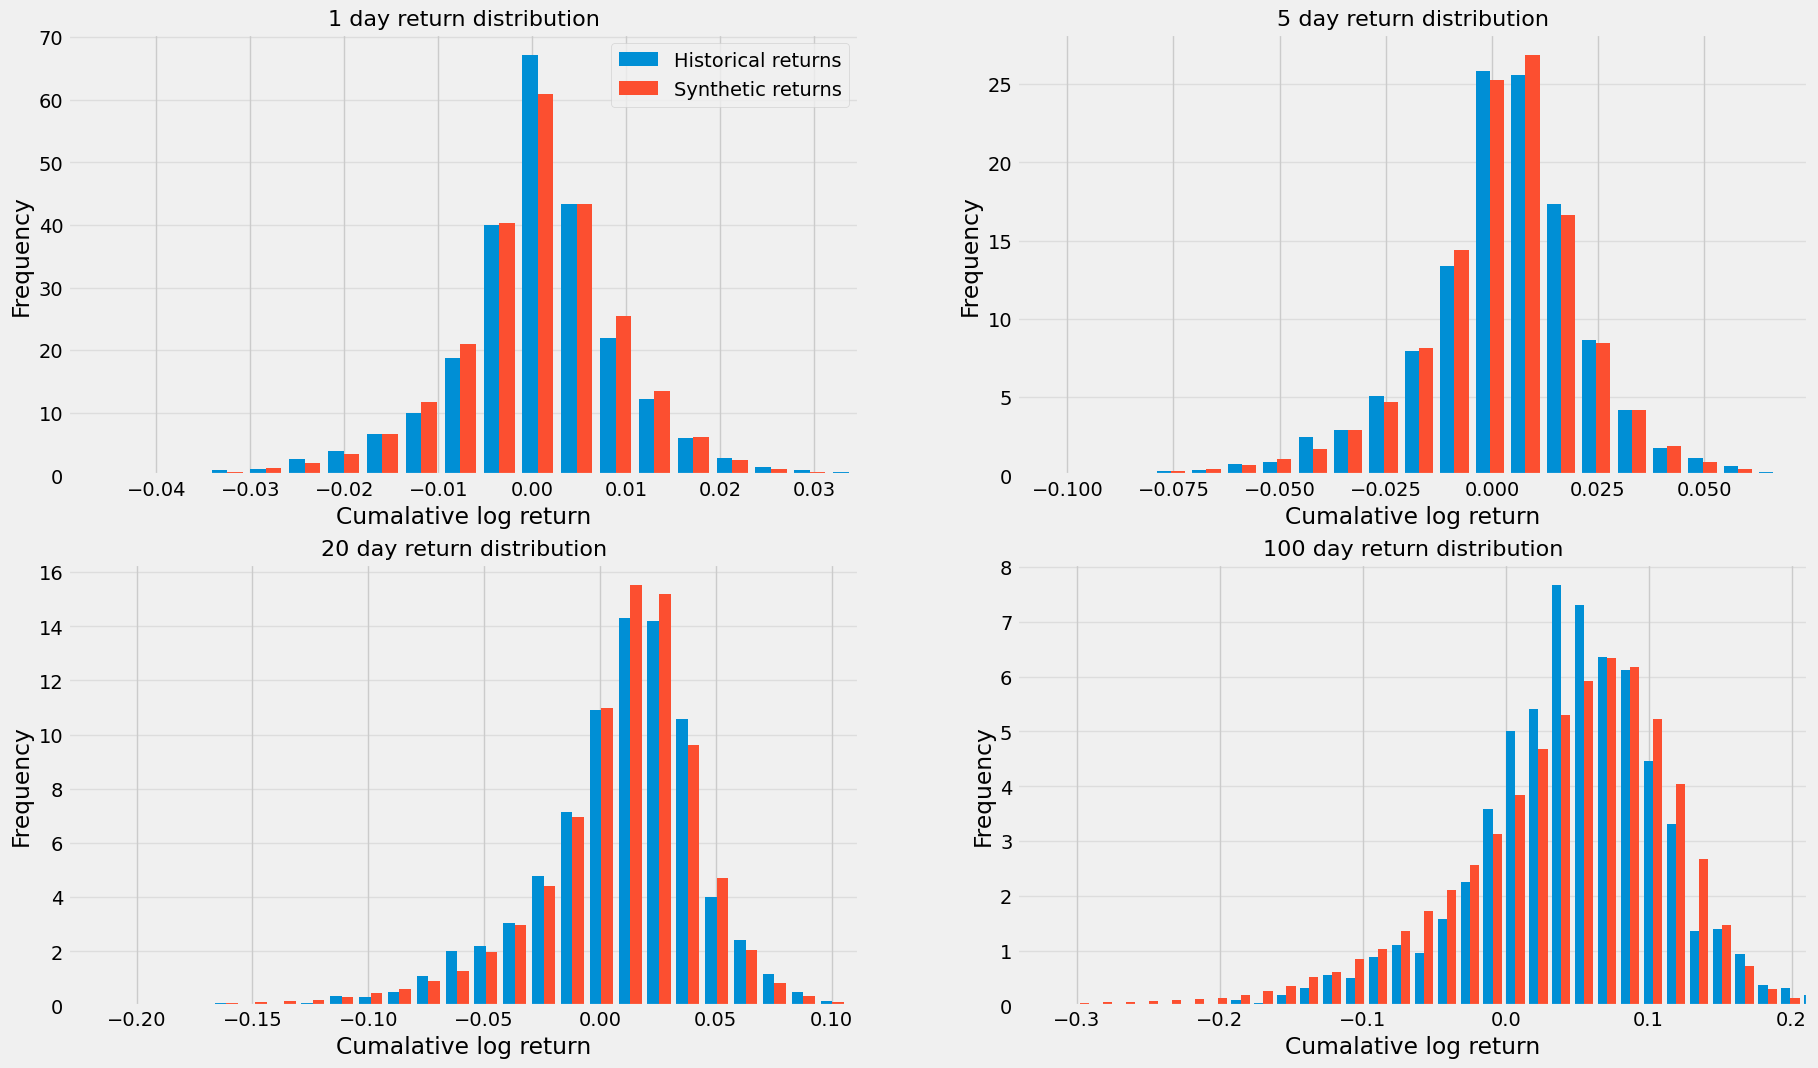

In [11]:
n_bins = 50
windows = [1, 5, 20, 100]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))


for i in range(len(windows)):
    row = min(max(0, i-1), 1)
    col = i % 2
    real_dist = rolling_window(log_returns, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    fake_dist = rolling_window(y.T, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    axs[row, col].hist(np.array([real_dist, fake_dist], dtype='object'), bins=50, density=True)
    axs[row,col].set_xlim(*np.quantile(fake_dist, [0.001, .999]))
    
    axs[row,col].set_title('{} day return distribution'.format(windows[i]), size=16)
    axs[row,col].yaxis.grid(True, alpha=0.5)
    axs[row,col].set_xlabel('Cumalative log return')
    axs[row,col].set_ylabel('Frequency')

axs[0,0].legend(['Historical returns', 'Synthetic returns'])

[Text(0.5, 0, 'Lag (number of days'),
 Text(0.5, 0, 'Lag (number of days'),
 Text(0.5, 0, 'Lag (number of days'),
 Text(0.5, 0, 'Lag (number of days')]

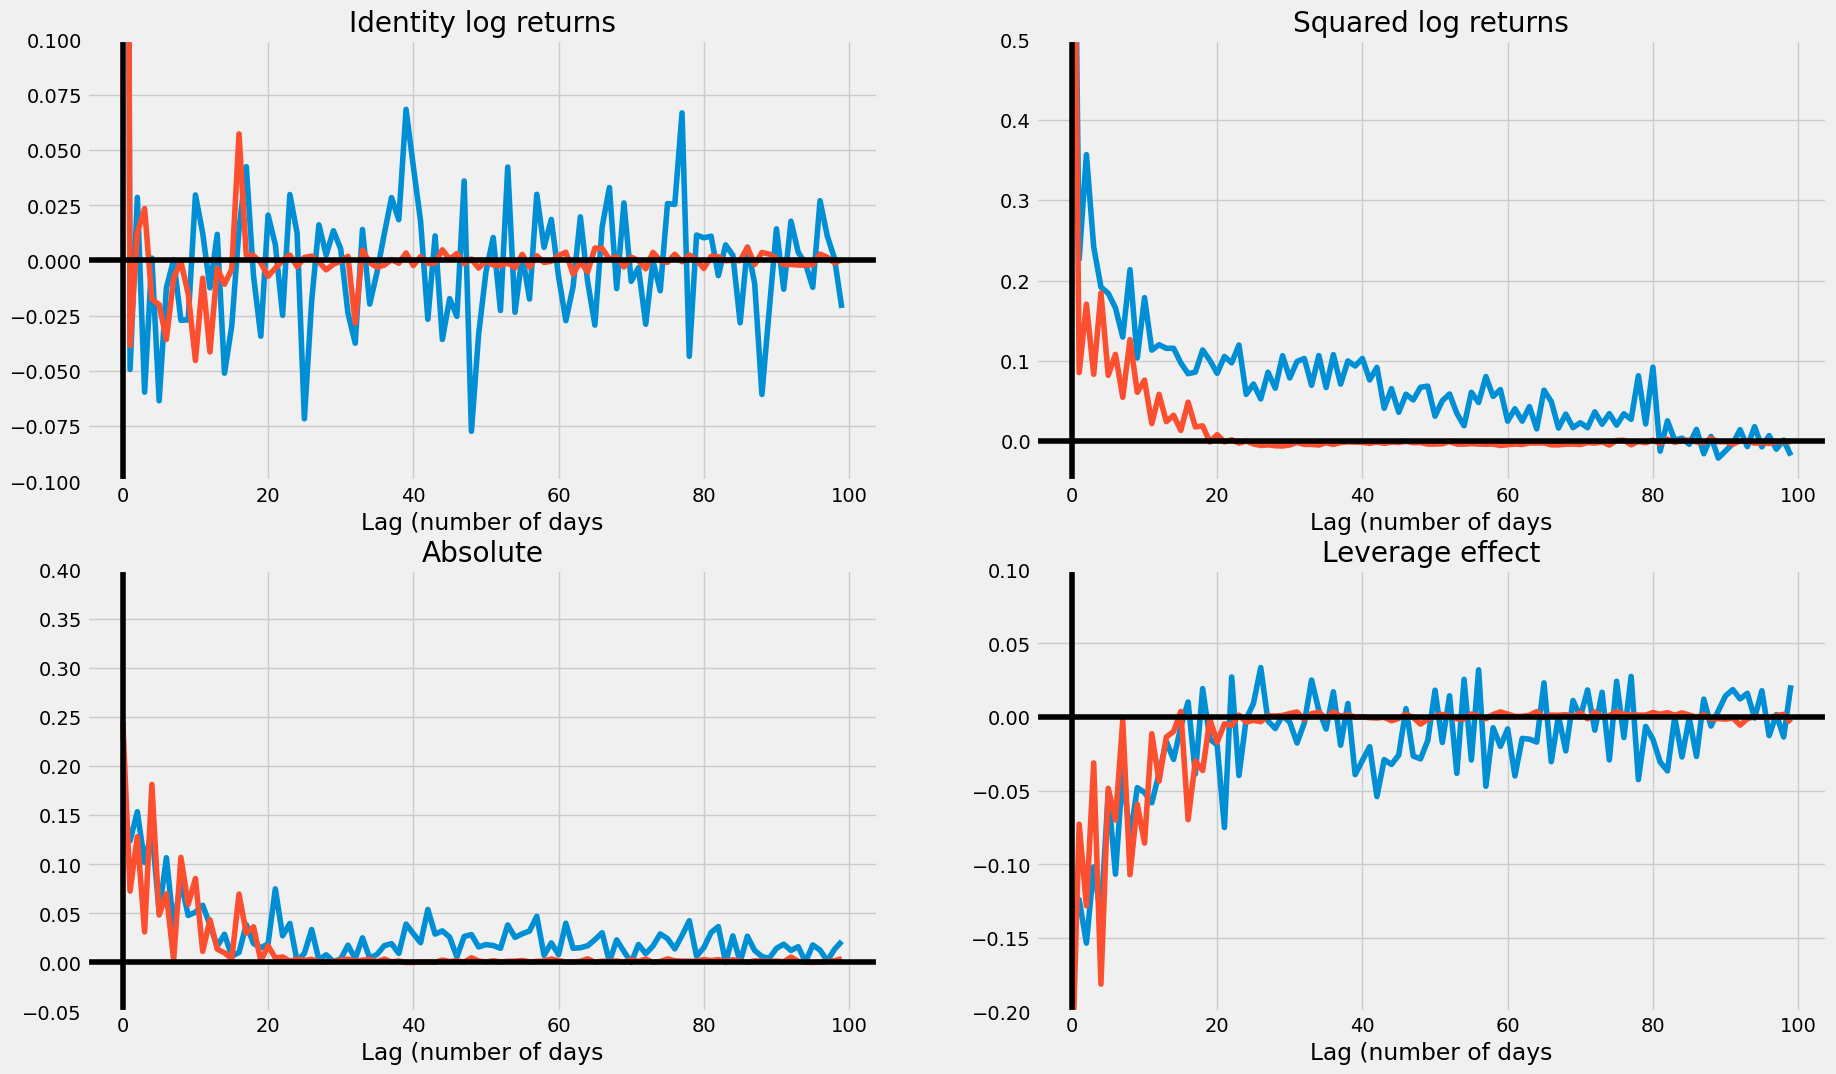

In [12]:

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))

axs[0,0].plot(acf(log_returns, 100))
axs[0,0].plot(acf(y.T, 100).mean(axis=1))
axs[0,0].set_ylim(-0.1, 0.1)
axs[0,0].set_title('Identity log returns')
axs[0,1].plot(acf(log_returns**2, 100))
axs[0,1].set_ylim(-0.05, 0.5)
axs[0,1].plot(acf(y.T**2, 100).mean(axis=1))
axs[0,1].set_title('Squared log returns')
axs[1,0].plot(abs(acf(log_returns, 100, le=True)))
axs[1,0].plot(abs(acf(y.T, 100, le=True).mean(axis=1)))
axs[1,0].set_ylim(-0.05, 0.4)
axs[1,0].set_title('Absolute')
axs[1,1].plot(acf(log_returns, 100, le=True))
axs[1,1].plot(acf(y.T, 100, le=True).mean(axis=1))
axs[1,1].set_ylim(-0.2, 0.1)
axs[1,1].set_title('Leverage effect')


for ax in axs.flat: 
  ax.grid(True)
  ax.axhline(y=0, color='k')
  ax.axvline(x=0, color='k')
plt.setp(axs, xlabel='Lag (number of days')